# MNISET
This notebook shows how to load the [MNISET](https://github.com/wouterkool/MNISET) dataset that was created as a side-effect of creating the [SET Finder](https://www.set-finder.com) app.

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import math
import numpy as np

## Load the data

In [2]:
def load_mniset(datadir='data', dataset_url='https://github.com/wouterkool/MNISET/raw/master/data/MNISET.npz'):
    os.makedirs(datadir, exist_ok=True)
    dataset_filename = os.path.join(datadir, os.path.split(dataset_url)[-1])
    if not os.path.isfile(dataset_filename):
        # download
        from urllib import request
        request.urlretrieve(dataset_url, dataset_filename)
    return np.load(dataset_filename)

mniset = load_mniset()
print("Keys:", list(mniset.keys()))

x_train, y_train = mniset['x_train'] / 255., mniset['y_train']
x_test, y_test = mniset['x_test'] / 255., mniset['y_test']

print(len(x_train), " train images, ", len(x_test), "test images")
print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)

Keys: ['x_train', 'y_train', 'x_test', 'y_test', 'labels', 'label_imgs', 'feature_names', 'feature_labels']
3036  train images,  922 test images
x_train.shape (3036, 28, 28, 3)
y_train.shape (3036,)


## Plot random sample

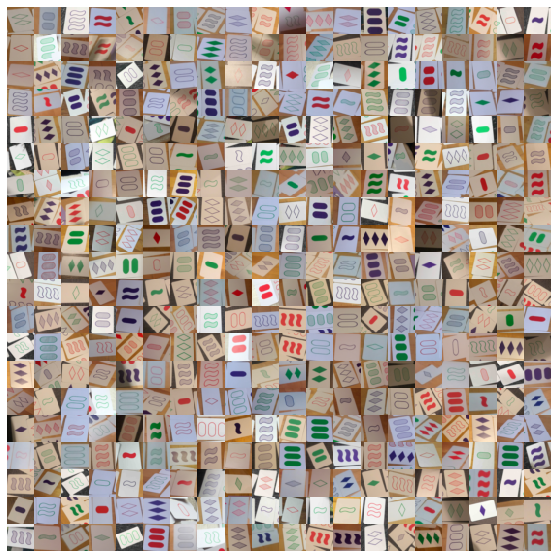

In [3]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def tile(imgs, n=20):
    return np.vstack([np.hstack(img_chunk) for img_chunk in chunks(imgs, n)])

def plot_sample(x):
    nrows = int(np.sqrt(len(x)) + 0.5)
    ncols = len(x) // nrows + (1 if len(x) % nrows != 0 else 0)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(tile(x, ncols), cmap='gray' if x.ndim == 3 else None)
    plt.axis('off')
    plt.show()
    
sample_idx = np.random.choice(len(x_train), 400)
plot_sample(x_train[sample_idx])

## Plot frequencies of classes

Train num classes 81 , min freq. 20 , max freq. 57 , avg freq. 37.48148148148148


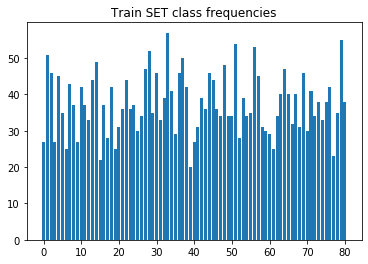

Test num classes 81 , min freq. 2 , max freq. 23 , avg freq. 11.382716049382717


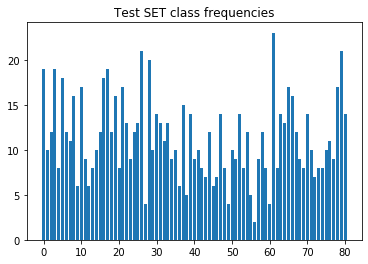

In [4]:
num_classes = len(mniset['labels'])

freq_train = np.bincount(y_train)
assert len(freq_train) == num_classes
assert (freq_train > 0).all()
print("Train num classes", num_classes, 
      ", min freq.", freq_train.min(), 
      ", max freq.", freq_train.max(), 
      ", avg freq.", freq_train.mean())
plt.bar(np.arange(num_classes), freq_train)
plt.title("Train SET class frequencies")
plt.show()

freq_test = np.bincount(y_test)
assert len(freq_test) == num_classes
assert (freq_test > 0).all()
print("Test num classes", num_classes, 
      ", min freq.", freq_test.min(), 
      ", max freq.", freq_test.max(), 
      ", avg freq.", freq_test.mean())
plt.bar(np.arange(num_classes), freq_test)
plt.title("Test SET class frequencies")
plt.show()

## Plot classes

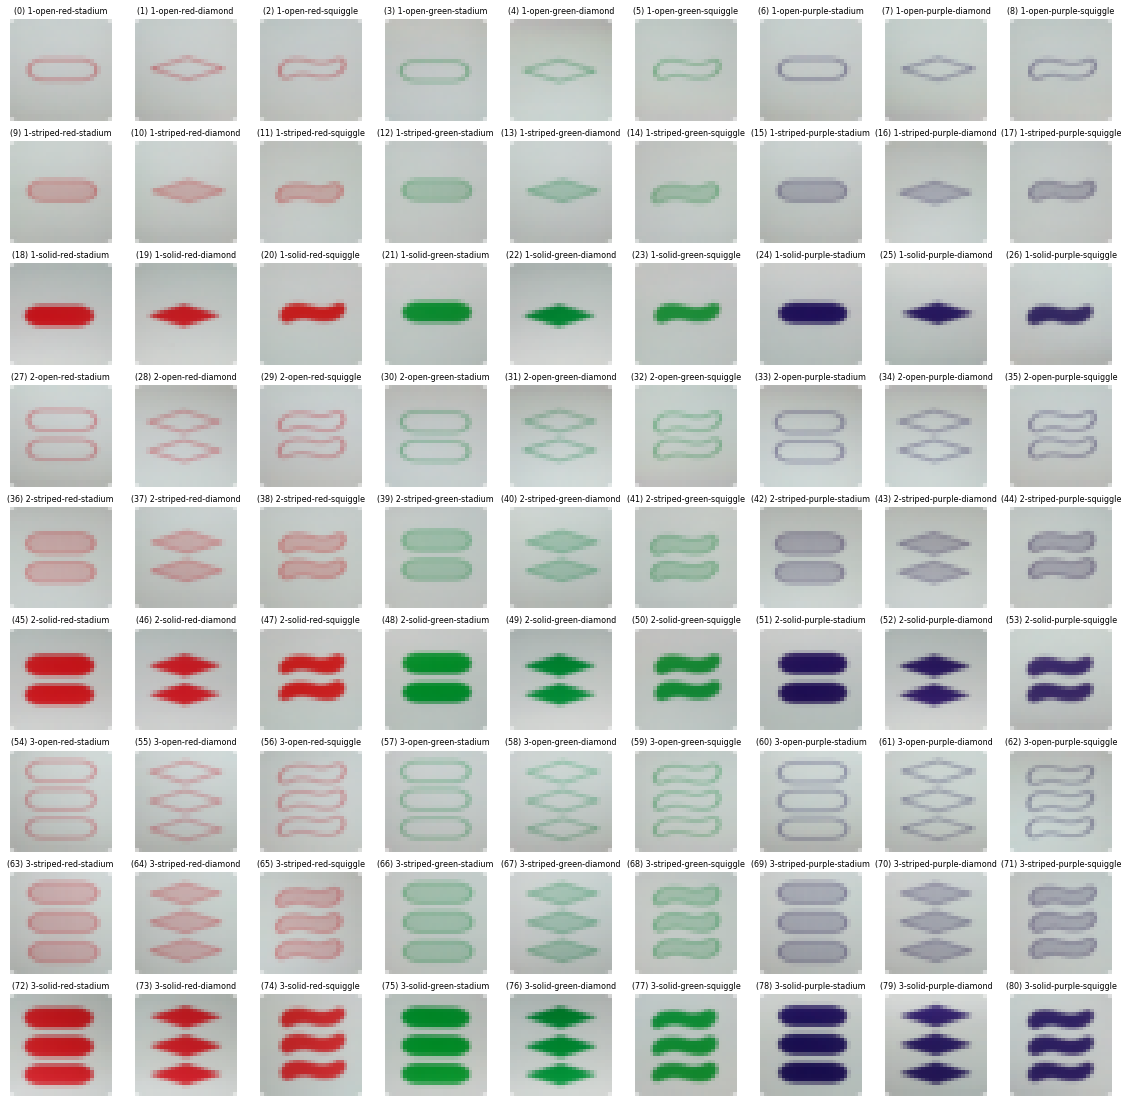

In [5]:
def plot_classes(label_imgs, labels, title=None):
    num_classes = len(labels)
    cols = 9 if num_classes > 9 else 3
    rows = num_classes // cols
    assert num_classes % cols == 0
    fig, axarr = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
    for i, (label_img, label) in enumerate(zip(label_imgs, labels)):
        row, col = i // cols, i % cols
        ax = axarr[row, col] if rows > 1 else axarr[col]
        ax.imshow(label_img, cmap='gray' if label_img.ndim == 2 else None)
        ax.set_title(f'({i}) {label}', fontsize=8)
        ax.axis('off')
    if title is not None:
        plt.suptitle(title, y=1.02)
    plt.show()
    
label_imgs = mniset['label_imgs']
labels = mniset['labels']
plot_classes(label_imgs, labels)

## Split classes
We can split the classes into separate classes for separate features to treat them as simpler classification problems.

Feature names: ['qty' 'fill' 'color' 'shape']
Feature labels:
[['1' '2' '3']
 ['open' 'striped' 'solid']
 ['red' 'green' 'purple']
 ['stadium' 'diamond' 'squiggle']]


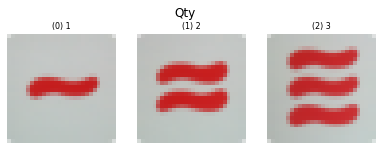

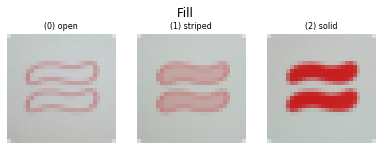

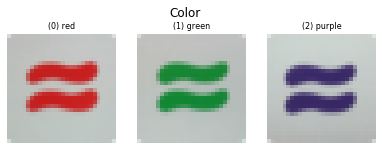

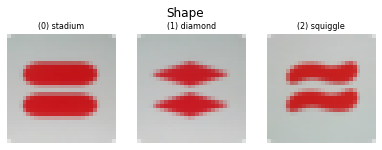

In [6]:
def split_classes(y):
    # See plot_classes
    row, col = y // 9, y % 9
    qty, fill = row // 3, row % 3
    color, shape = col // 3, col % 3
    return qty, fill, color, shape

# Let's have a look at different feature labels
feature_labels = mniset['feature_labels']
print("Feature names:", mniset['feature_names'])
print("Feature labels:")
print(feature_labels)
labels_qty, labels_fill, labels_color, labels_shape = feature_labels

# We can split the full classes into individual classes
y_classes = np.arange(len(labels)).astype(int)
qty_classes, fill_classes, color_classes, shape_classes = split_classes(y_classes)

# These can be used as train/test classes for individual classification problems
qty_train, fill_train, color_train, shape_train = split_classes(y_train)
qty_test, fill_test, color_test, shape_test = split_classes(y_test)

# Define which classes are default for each feature
is_default_qty = qty_classes == 1  # '2'
is_default_fill = fill_classes == 2  # 'solid'
is_default_color = color_classes == 0  # 'red'
is_default_shape = shape_classes == 2  # 'squiggle'

# Find label images
label_imgs_qty = label_imgs[is_default_fill & is_default_color & is_default_shape]
label_imgs_fill = label_imgs[is_default_qty & is_default_color & is_default_shape]
label_imgs_color = label_imgs[is_default_qty & is_default_fill & is_default_shape]
label_imgs_shape = label_imgs[is_default_qty & is_default_fill & is_default_color]

plot_classes(label_imgs_qty, labels_qty, title='Qty')
plot_classes(label_imgs_fill, labels_fill, title='Fill')
plot_classes(label_imgs_color, labels_color, title='Color')
plot_classes(label_imgs_shape, labels_shape, title='Shape')

## Grayscale MNISET
We can make a grayscale MNISET dataset just like the original MNIST dataset. While not required, we may also remove the color feature from the classes for a classification problem with 27 classes.

x_train_gray.shape (3036, 28, 28)


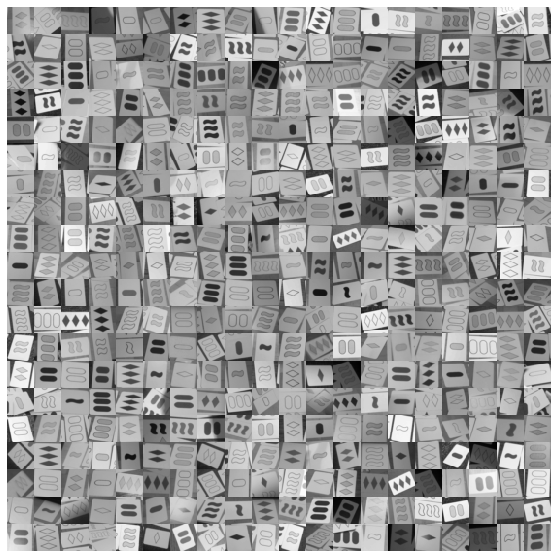

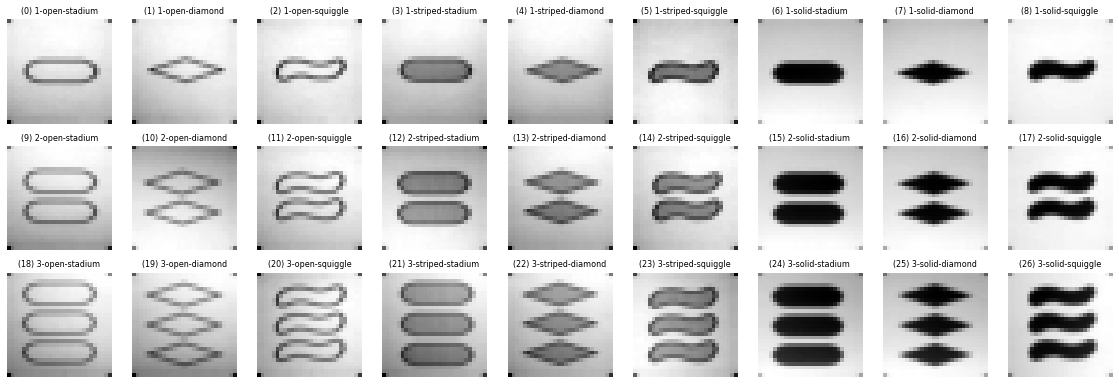

In [7]:
import itertools
def make_labels(*args):
    return np.array(["-".join(feats) for feats in list(itertools.product(*args))])

feature_labels = mniset['feature_labels']
assert (make_labels(*feature_labels) == labels).all()

# qty_values, fill_values, color_values, shape_values = feature_values
labels_qty, labels_fill, labels_color, labels_shape = feature_labels
labels_gray = make_labels(labels_qty, labels_fill, labels_shape)
# Arbitrarily use the red images (color == 0) as labels
is_default_color = color_classes == 0  # 'red'
label_imgs_gray = label_imgs[is_default_color].mean(-1)

# Training SET
x_train_gray = x_train.mean(-1)  # MNIST-like grayscale
y_train_gray = qty_train * 9 + fill_train * 3 + shape_train
# Test SET
x_test_gray = x_test.mean(-1)  # MNIST-like grayscale
y_test_gray = qty_test * 9 + fill_test * 3 + shape_test

print("x_train_gray.shape", x_train_gray.shape)

sample_idx = np.random.choice(len(x_train_gray), 400)
plot_sample(x_train_gray[sample_idx])

plot_classes(label_imgs_gray, labels_gray)

## Plot full dataset

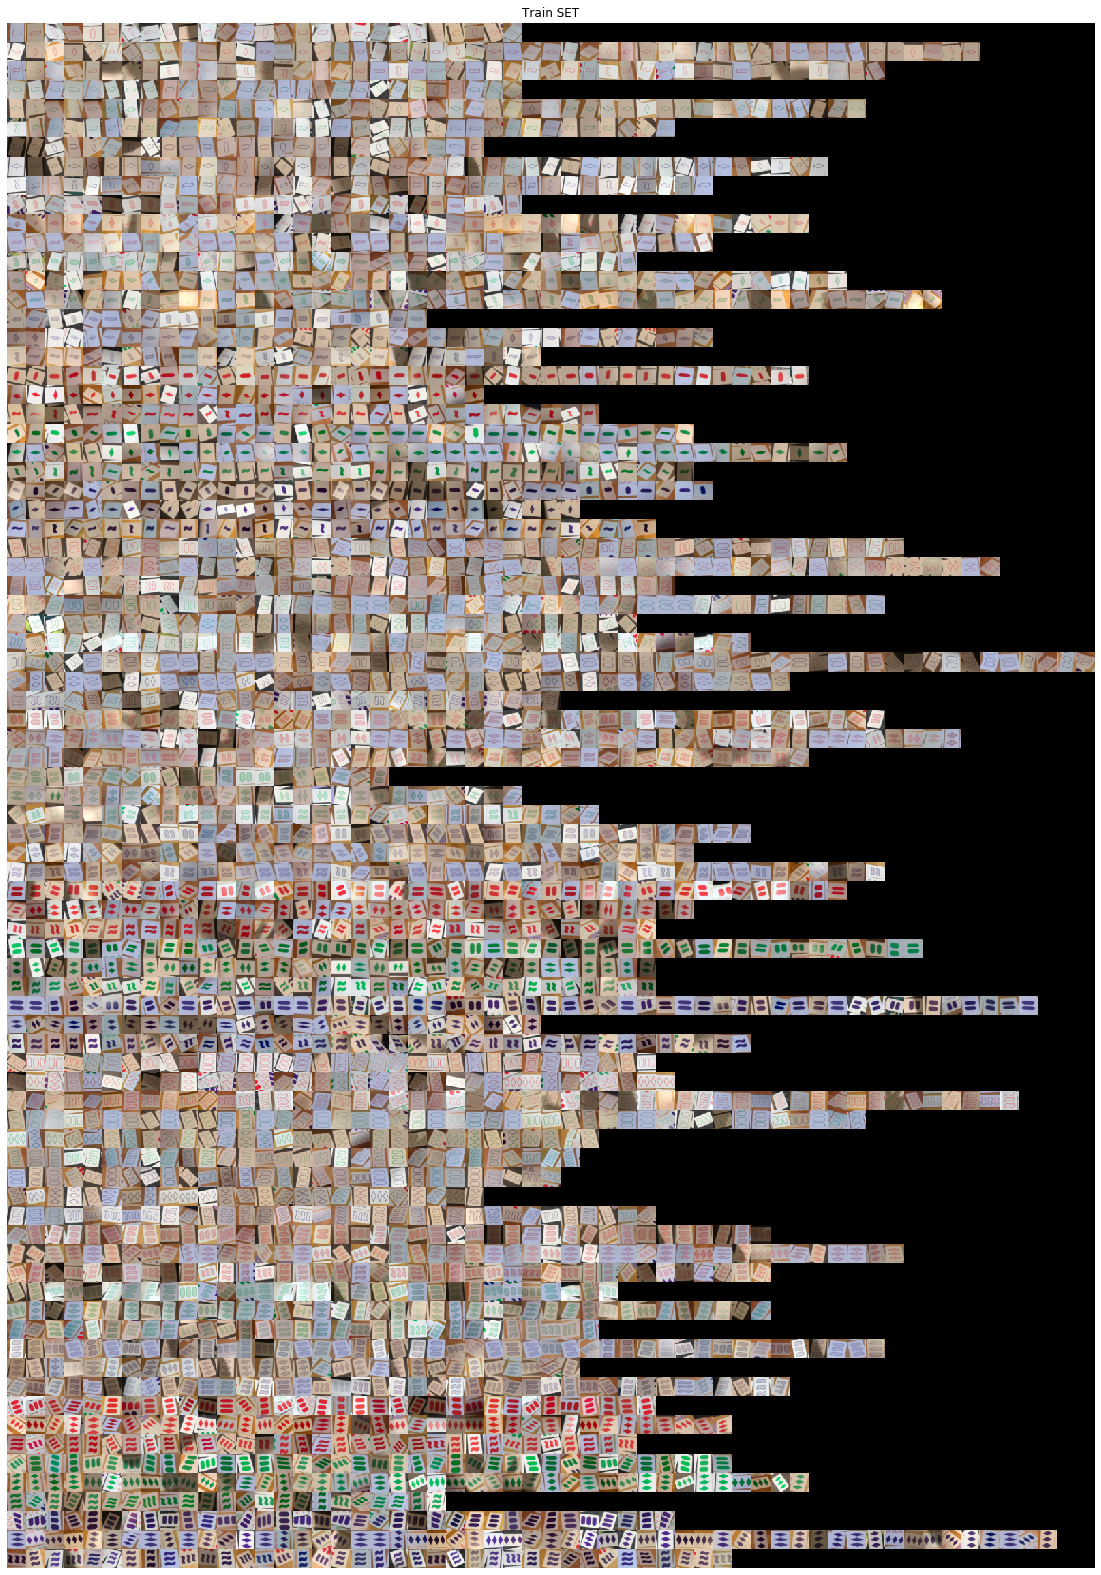

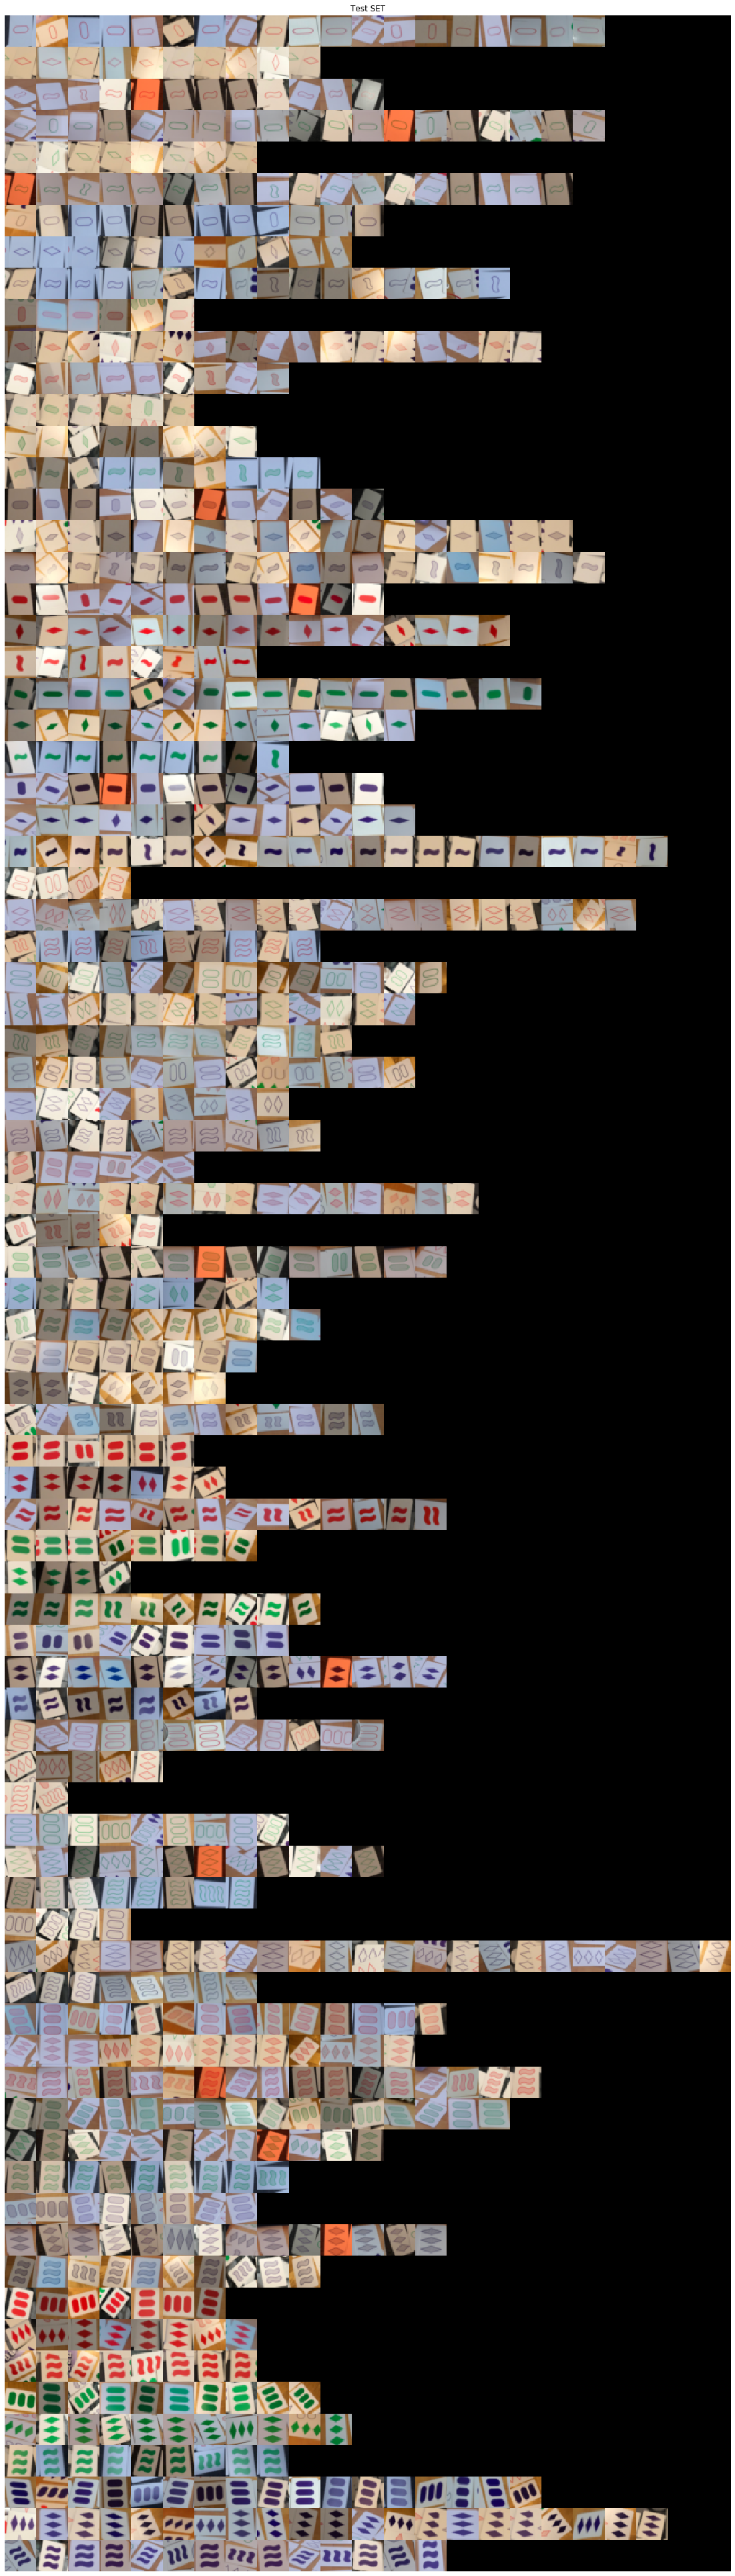

In [8]:
def plot_all(x, y, num_classes=81, max_per_class=20, title=''):
    rows = []
    for i in range(num_classes):
        idx = np.where(y == i)[0]
        idx = np.random.choice(idx, min(max_per_class, len(idx)), replace=False)
        x_i = x[idx]
        x_i = np.pad(x_i, ((0, max_per_class - len(x_i)), (0, 0), (0, 0), (0, 0)), mode='constant')
        rows.append(np.hstack(x_i))

    fig, ax = plt.subplots(figsize=(20, 20 / max_per_class * num_classes))
    ax.imshow(np.vstack(rows))
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_all(x_train, y_train, max_per_class=freq_train.max(), title='Train SET')

freq_test = np.bincount(y_test)
plot_all(x_test, y_test, max_per_class=freq_test.max(), title='Test SET')